<a href="https://colab.research.google.com/github/mihneaciorica/ecgtemplatematching/blob/main/clasificatori_liniari.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Clasificatori liniari (implementare in scikit-learn)

Setul de tate utilizat -> https://ai.stanford.edu/~amaas/data/sentiment/ Large Movie Review Dataset

References:

ACL 2011 paper [https://ai.stanford.edu/~amaas/papers/wvSent_acl2011.bib]

Publications Using the Dataset
Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. (2011). Learning Word Vectors for Sentiment Analysis. The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011).

NLP tokenization -> https://www.kaggle.com/code/lakshmi25npathi/sentiment-analysis-of-imdb-movie-reviews


In [14]:
#importarea package-urilor necesare
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import spacy
import re,string,unicodedata
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

from google.colab import drive

nltk.download('stopwords')

drive.mount('/content/drive')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:

movie_dataset_path='../content/sample_data/IMDBDataset.csv'

movie_dataset = pd.read_csv(movie_dataset_path,
                 header=0,
                 engine="python",
                 error_bad_lines=False,
                 encoding='utf-8')

<ipython-input-5-fc663c7dbf6b>:3: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  movie_dataset = pd.read_csv(movie_dataset_path,
Skipping line 14211: unexpected end of data


In [6]:
#print(movie_dataset.iloc[:,0])
print(movie_dataset.iloc[:,0]) # Trebuie sa transform primul row in column names

movie_dataset.columns=['review','sentiment'] #nu exista decat o coloana!

0        One of the other reviewers has mentioned that ...
1        A wonderful little production. <br /><br />The...
2        I thought this was a wonderful way to spend ti...
3        Basically there's a family where a little boy ...
4        Petter Mattei's "Love in the Time of Money" is...
                               ...                        
14204    Any Batman fan will know just how great the fi...
14205    ***SPOILERS*** ***SPOILERS*** It's easy to see...
14206    Have you heard the theory of cloning redundanc...
14207    There's not that much to say in the end. One w...
14208    ELEPHANT WALK may not be the acme of literatur...
Name: review, Length: 14209, dtype: object


In [7]:
movie_dataset.iloc[0][1]

'positive'

In [ ]:
# cred ca trebuie recitit setul de date si utilizat parametrul header=0 => acum functioneaza

In [8]:
# feature variable sau cum este denumita in cartea Domnului Profesor Enachescu variabila endogena

X= movie_dataset.iloc[:,0]

# variabila target sau variabila exogena

y=movie_dataset.iloc[:,1]

# variabila endogena trebuie extrasa prin metode NLP


In [9]:
# Analiza exploratorie pentru a intelege dimensiunea setului de date

#sentiment count
movie_dataset['sentiment'].value_counts()

#print(movie_dataset.shape)
#movie_dataset.head(10)

negative    7180
positive    7029
Name: sentiment, dtype: int64

In [11]:
#Reajustez setul de antrenament si cel de test in urma movie_dataset.shape
train_reviews=movie_dataset.review[:12000]
train_sentiments=movie_dataset.sentiment[:12000]
#test dataset
test_reviews=movie_dataset.review[12000:]
test_sentiments=movie_dataset.sentiment[12000:]
print(train_reviews.shape,train_sentiments.shape)
print(test_reviews.shape,test_sentiments.shape)

(12000,) (12000,)
(2209,) (2209,)


In [15]:
#Tokenization of text
tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

In [16]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
#Apply function on review column
movie_dataset['review']=movie_dataset['review'].apply(denoise_text)

<ipython-input-16-2a70dd9c90a8>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [17]:
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
#Apply function on review column
movie_dataset['review']=movie_dataset['review'].apply(remove_special_characters)

In [18]:
#set stopwords to english
stop=set(stopwords.words('english'))
print(stop)

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text
#Apply function on review column
movie_dataset['review']=movie_dataset['review'].apply(remove_stopwords)

{'that', 'themselves', 'my', 'than', 'should', "wasn't", 'you', 'about', 'some', 'them', 'will', "won't", 'those', 'its', 'once', 'any', 'be', 'to', 'with', 'yourself', 'own', 'itself', "needn't", 'from', "mightn't", 'we', 'few', 'because', 'most', 'who', 'these', "you're", "wouldn't", 'during', "she's", 'if', "hadn't", 'can', 'a', "you'll", 'through', 'does', 'of', 'now', 'ma', "you'd", 'am', 'while', "hasn't", 'mightn', 'until', "shouldn't", 'wouldn', 's', 'but', 'only', 'was', 'by', 'between', 'what', 'which', 'for', 'were', 'an', 'again', 'hasn', "should've", 'before', 'their', 'm', 'her', "didn't", 'why', 'wasn', 'yours', 'yourselves', 'his', 'under', 'here', 'too', 'on', 'doesn', 'nor', 'further', 'above', 'it', "you've", 'other', 'did', 'then', 'he', 'no', 'they', "shan't", 're', 'him', 'both', 't', 'whom', 'aren', 'haven', 'at', 'me', 'shan', 'shouldn', 'myself', 'ourselves', 'isn', 'over', 'more', 'mustn', 'being', 'do', 'and', 'couldn', 'is', 'how', 'all', 'she', 'off', 've',

In [19]:
#normalized train reviews
norm_train_reviews=movie_dataset.review[:12000]
norm_train_reviews[0]
#Normalized test reviews
norm_test_reviews=movie_dataset.review[12000:]


In [20]:
#Count vectorizer for bag of words
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
#transformed train reviews
cv_train_reviews=cv.fit_transform(norm_train_reviews)
#transformed test reviews
cv_test_reviews=cv.transform(norm_test_reviews)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)
#vocab=cv.get_feature_names()-toget feature names

BOW_cv_train: (12000, 2265144)
BOW_cv_test: (2209, 2265144)


In [ ]:
#Tfidf vectorizer
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
#transformed train reviews
tv_train_reviews=tv.fit_transform(norm_train_reviews)
#transformed test reviews
tv_test_reviews=tv.transform(norm_test_reviews)
print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)
print('Tfidf_test:',tv_test_reviews[0])

Tfidf_train: (12000, 2265144)
Tfidf_test: (3808, 2265144)
Tfidf_test:   (0, 2199860)	0.5773502691896257
  (0, 1303134)	0.5773502691896257
  (0, 1269549)	0.5773502691896257


In [22]:
#Preprocesare cu StandardScaler =  Standardizarea datelor https://scikit-learn.org/stable/modules/preprocessing.html
#parametrul with_mean=False este pentru a evita eroarea privind sparse matrices
from sklearn import preprocessing



scaler=preprocessing.StandardScaler(with_mean=False)
tv_train_reviews_scaled=scaler.fit_transform(tv_train_reviews)

#Preprocesare cu StandardScaler =  Standardizarea datelor https://scikit-learn.org/stable/modules/preprocessing.html
#parametrul with_mean=False este pentru a evita eroarea privind sparse matrices


cv_scaler=preprocessing.StandardScaler(with_mean=False).fit(cv_train_reviews)
cv_train_reviews_scaled=scaler.transform(cv_train_reviews)

NameError: ignored

In [ ]:
#labeling the sentiment data
lb=LabelBinarizer()
#transformed sentiment data
sentiment_data=lb.fit_transform(movie_dataset['sentiment'])
print(sentiment_data.shape)

(15808, 1)


In [ ]:
#Spliting the sentiment data
train_sentiments=sentiment_data[:12000]
test_sentiments=sentiment_data[12000:]
print(train_sentiments)
print(test_sentiments)

[[1]
 [1]
 [1]
 ...
 [0]
 [1]
 [0]]
[[1]
 [0]
 [1]
 ...
 [1]
 [1]
 [1]]


In [ ]:
#training the model
lr=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)
#Fitting the model for Bag of words
lr_bow=lr.fit(cv_train_reviews_scaled,train_sentiments)
print(lr_bow)
#Fitting the model for tfidf features
lr_tfidf=lr.fit(tv_train_reviews_scaled,train_sentiments)
print(lr_tfidf)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1, max_iter=500, random_state=42)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1, max_iter=500, random_state=42)


In [ ]:
#Predicting the model for bag of words
lr_bow_predict=lr.predict(cv_test_reviews)
print(lr_bow_predict)
##Predicting the model for tfidf features
lr_tfidf_predict=lr.predict(tv_test_reviews)
print(lr_tfidf_predict)

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


In [ ]:
#Accuracy score for bag of words
lr_bow_score=accuracy_score(test_sentiments,lr_bow_predict)
print("lr_bow_score :",lr_bow_score)
#Accuracy score for tfidf features
lr_tfidf_score=accuracy_score(test_sentiments,lr_tfidf_predict)
print("lr_tfidf_score :",lr_tfidf_score)

lr_bow_score : 0.5181197478991597
lr_tfidf_score : 0.5181197478991597


In [ ]:
#Classification report for bag of words
lr_bow_report=classification_report(test_sentiments,lr_bow_predict,target_names=['Positive','Negative'],zero_division=0)
print(lr_bow_report)

#Classification report for tfidf features
lr_tfidf_report=classification_report(test_sentiments,lr_tfidf_predict,target_names=['Positive','Negative'],zero_division=0)
print(lr_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.52      1.00      0.68      1973
    Negative       0.00      0.00      0.00      1835

    accuracy                           0.52      3808
   macro avg       0.26      0.50      0.34      3808
weighted avg       0.27      0.52      0.35      3808

              precision    recall  f1-score   support

    Positive       0.52      1.00      0.68      1973
    Negative       0.00      0.00      0.00      1835

    accuracy                           0.52      3808
   macro avg       0.26      0.50      0.34      3808
weighted avg       0.27      0.52      0.35      3808



# Recall 0 in continuare pentru LogisticRegression()
#Voi modifica parametrul penalty

In [ ]:
#training the model
lr=LogisticRegression(max_iter=500,C=1,random_state=42)
#Fitting the model for Bag of words
lr_bow=lr.fit(cv_train_reviews,train_sentiments)
print(lr_bow)
#Fitting the model for tfidf features
lr_tfidf=lr.fit(tv_train_reviews,train_sentiments)
print(lr_tfidf)

#Predicting the model for bag of words
lr_bow_predict=lr.predict(cv_test_reviews)
print(lr_bow_predict)
##Predicting the model for tfidf features
lr_tfidf_predict=lr.predict(tv_test_reviews)
print(lr_tfidf_predict)

#Accuracy score for bag of words
lr_bow_score=accuracy_score(test_sentiments,lr_bow_predict)
print("lr_bow_score :",lr_bow_score)
#Accuracy score for tfidf features
lr_tfidf_score=accuracy_score(test_sentiments,lr_tfidf_predict)
print("lr_tfidf_score :",lr_tfidf_score)

#Classification report for bag of words
lr_bow_report=classification_report(test_sentiments,lr_bow_predict,target_names=['Positive','Negative'],zero_division=0)
print(lr_bow_report)

#Classification report for tfidf features
lr_tfidf_report=classification_report(test_sentiments,lr_tfidf_predict,target_names=['Positive','Negative'],zero_division=0)
print(lr_tfidf_report)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1, max_iter=500, random_state=42)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1, max_iter=500, random_state=42)
[0 0 1 ... 0 1 0]
[0 0 0 ... 0 1 0]
lr_bow_score : 0.7198004201680672
lr_tfidf_score : 0.7064075630252101
              precision    recall  f1-score   support

    Positive       0.72      0.76      0.74      1973
    Negative       0.73      0.67      0.70      1835

    accuracy                           0.72      3808
   macro avg       0.72      0.72      0.72      3808
weighted avg       0.72      0.72      0.72      3808

              precision    recall  f1-score   support

    Positive       0.68      0.83      0.75      1973
    Negative       0.76      0.58      0.65      1835

    accuracy                           0.71      3808
   macro avg       0.72      0.70      0.70      3808
weighted avg       0.72      0.71      0.70      3808



In [ ]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,lr_bow_predict,labels=[1,0])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,lr_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[   0 1835]
 [   0 1973]]
[[   0 1835]
 [   0 1973]]


In [ ]:

#training the linear svm
svm=SGDClassifier(loss='hinge',max_iter=500,random_state=42)
#fitting the svm for bag of words
svm_bow=svm.fit(cv_train_reviews_scaled,train_sentiments)
print(svm_bow)
#fitting the svm for tfidf features
svm_tfidf=svm.fit(tv_train_reviews_scaled,train_sentiments)
print(svm_tfidf)

#Predicting the model for bag of words
svm_bow_predict=svm.predict(cv_test_reviews)
print(svm_bow_predict)
#Predicting the model for tfidf features
svm_tfidf_predict=svm.predict(tv_test_reviews)
print(svm_tfidf_predict)

#Accuracy score for bag of words
svm_bow_score=accuracy_score(test_sentiments,svm_bow_predict)
print("svm_bow_score :",svm_bow_score)
#Accuracy score for tfidf features
svm_tfidf_score=accuracy_score(test_sentiments,svm_tfidf_predict)
print("svm_tfidf_score :",svm_tfidf_score)

#Classification report for bag of words
svm_bow_report=classification_report(test_sentiments,svm_bow_predict,target_names=['Positive','Negative'])
print(svm_bow_report)
#Classification report for tfidf features
svm_tfidf_report=classification_report(test_sentiments,svm_tfidf_predict,target_names=['Positive','Negative'])
print(svm_tfidf_report)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDClassifier(max_iter=500, random_state=42)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDClassifier(max_iter=500, random_state=42)
[0 0 1 ... 1 1 0]
[0 0 1 ... 1 1 0]
svm_bow_score : 0.7198004201680672
svm_tfidf_score : 0.7198004201680672
              precision    recall  f1-score   support

    Positive       0.71      0.77      0.74      1973
    Negative       0.73      0.67      0.70      1835

    accuracy                           0.72      3808
   macro avg       0.72      0.72      0.72      3808
weighted avg       0.72      0.72      0.72      3808

              precision    recall  f1-score   support

    Positive       0.71      0.77      0.74      1973
    Negative       0.73      0.67      0.70      1835

    accuracy                           0.72      3808
   macro avg       0.72      0.72      0.72      3808
weighted avg       0.72      0.72      0.72      3808



In [1]:
#training the linear svm
svm=SGDClassifier(loss='log_loss',max_iter=500,random_state=42)
#fitting the svm for bag of words
svm_bow=svm.fit(cv_train_reviews_scaled,train_sentiments)
print(svm_bow)
#fitting the svm for tfidf features
svm_tfidf=svm.fit(tv_train_reviews_scaled,train_sentiments)
print(svm_tfidf)

#Predicting the model for bag of words
svm_bow_predict=svm.predict(cv_test_reviews)
print(svm_bow_predict)
#Predicting the model for tfidf features
svm_tfidf_predict=svm.predict(tv_test_reviews)
print(svm_tfidf_predict)

#Accuracy score for bag of words
svm_bow_score=accuracy_score(test_sentiments,svm_bow_predict)
print("svm_bow_score :",svm_bow_score)
#Accuracy score for tfidf features
svm_tfidf_score=accuracy_score(test_sentiments,svm_tfidf_predict)
print("svm_tfidf_score :",svm_tfidf_score)

#Classification report for bag of words
svm_bow_report=classification_report(test_sentiments,svm_bow_predict,target_names=['Positive','Negative'])
print(svm_bow_report)
#Classification report for tfidf features
svm_tfidf_report=classification_report(test_sentiments,svm_tfidf_predict,target_names=['Positive','Negative'])
print(svm_tfidf_report)

NameError: ignored

In [ ]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,svm_bow_predict,labels=[1,0])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,svm_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[1230  605]
 [ 462 1511]]
[[1230  605]
 [ 462 1511]]


In [ ]:
#training the model
mnb=MultinomialNB()
#fitting the svm for bag of words
mnb_bow=mnb.fit(cv_train_reviews_scaled,train_sentiments)
print(mnb_bow)
#fitting the svm for tfidf features
mnb_tfidf=mnb.fit(tv_train_reviews_scaled,train_sentiments)
print(mnb_tfidf)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB()
MultinomialNB()


In [ ]:
#Predicting the model for bag of words
mnb_bow_predict=mnb.predict(cv_test_reviews)
print(mnb_bow_predict)
#Predicting the model for tfidf features
mnb_tfidf_predict=mnb.predict(tv_test_reviews)
print(mnb_tfidf_predict)

[0 0 1 ... 1 1 0]
[0 0 1 ... 1 1 0]


In [ ]:
#Accuracy score for bag of words
mnb_bow_score=accuracy_score(test_sentiments,mnb_bow_predict)
print("mnb_bow_score :",mnb_bow_score)
#Accuracy score for tfidf features
mnb_tfidf_score=accuracy_score(test_sentiments,mnb_tfidf_predict)
print("mnb_tfidf_score :",mnb_tfidf_score)

mnb_bow_score : 0.7198004201680672
mnb_tfidf_score : 0.7198004201680672


In [ ]:
#Classification report for bag of words
mnb_bow_report=classification_report(test_sentiments,mnb_bow_predict,target_names=['Positive','Negative'])
print(mnb_bow_report)
#Classification report for tfidf features
mnb_tfidf_report=classification_report(test_sentiments,mnb_tfidf_predict,target_names=['Positive','Negative'])
print(mnb_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.71      0.77      0.74      1973
    Negative       0.73      0.67      0.70      1835

    accuracy                           0.72      3808
   macro avg       0.72      0.72      0.72      3808
weighted avg       0.72      0.72      0.72      3808

              precision    recall  f1-score   support

    Positive       0.71      0.77      0.74      1973
    Negative       0.73      0.67      0.70      1835

    accuracy                           0.72      3808
   macro avg       0.72      0.72      0.72      3808
weighted avg       0.72      0.72      0.72      3808



In [ ]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,mnb_bow_predict,labels=[1,0])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,mnb_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[ 907  445]
 [ 331 1125]]
[[ 907  445]
 [ 331 1125]]


Adaug modelul KNN

In [ ]:
#training the model KNN cu n_neighbors=2 intrucat variabila endogena nu poate avea decat doua valori: positive sau negative
knn=KNeighborsClassifier(n_neighbors=13)
#fitting the knn for bag of words  after flatening the train_sentiments using ravel
knn_bow=knn.fit(cv_train_reviews,np.ravel(train_sentiments))
print(knn_bow)
#fitting the knn for tfidf features after flatening the train_sentiments using ravel
knn_tfidf=knn.fit(tv_train_reviews,np.ravel(train_sentiments))
print(knn_tfidf)

KNeighborsClassifier(n_neighbors=13)
KNeighborsClassifier(n_neighbors=13)


In [ ]:
#Predicting the model for bag of words
knn_bow_predict=knn.predict(cv_test_reviews)
print(knn_bow_predict)
#Predicting the model for tfidf features
knn_tfidf_predict=knn.predict(tv_test_reviews)
print(knn_tfidf_predict)

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


KNN a durat 2m 28s

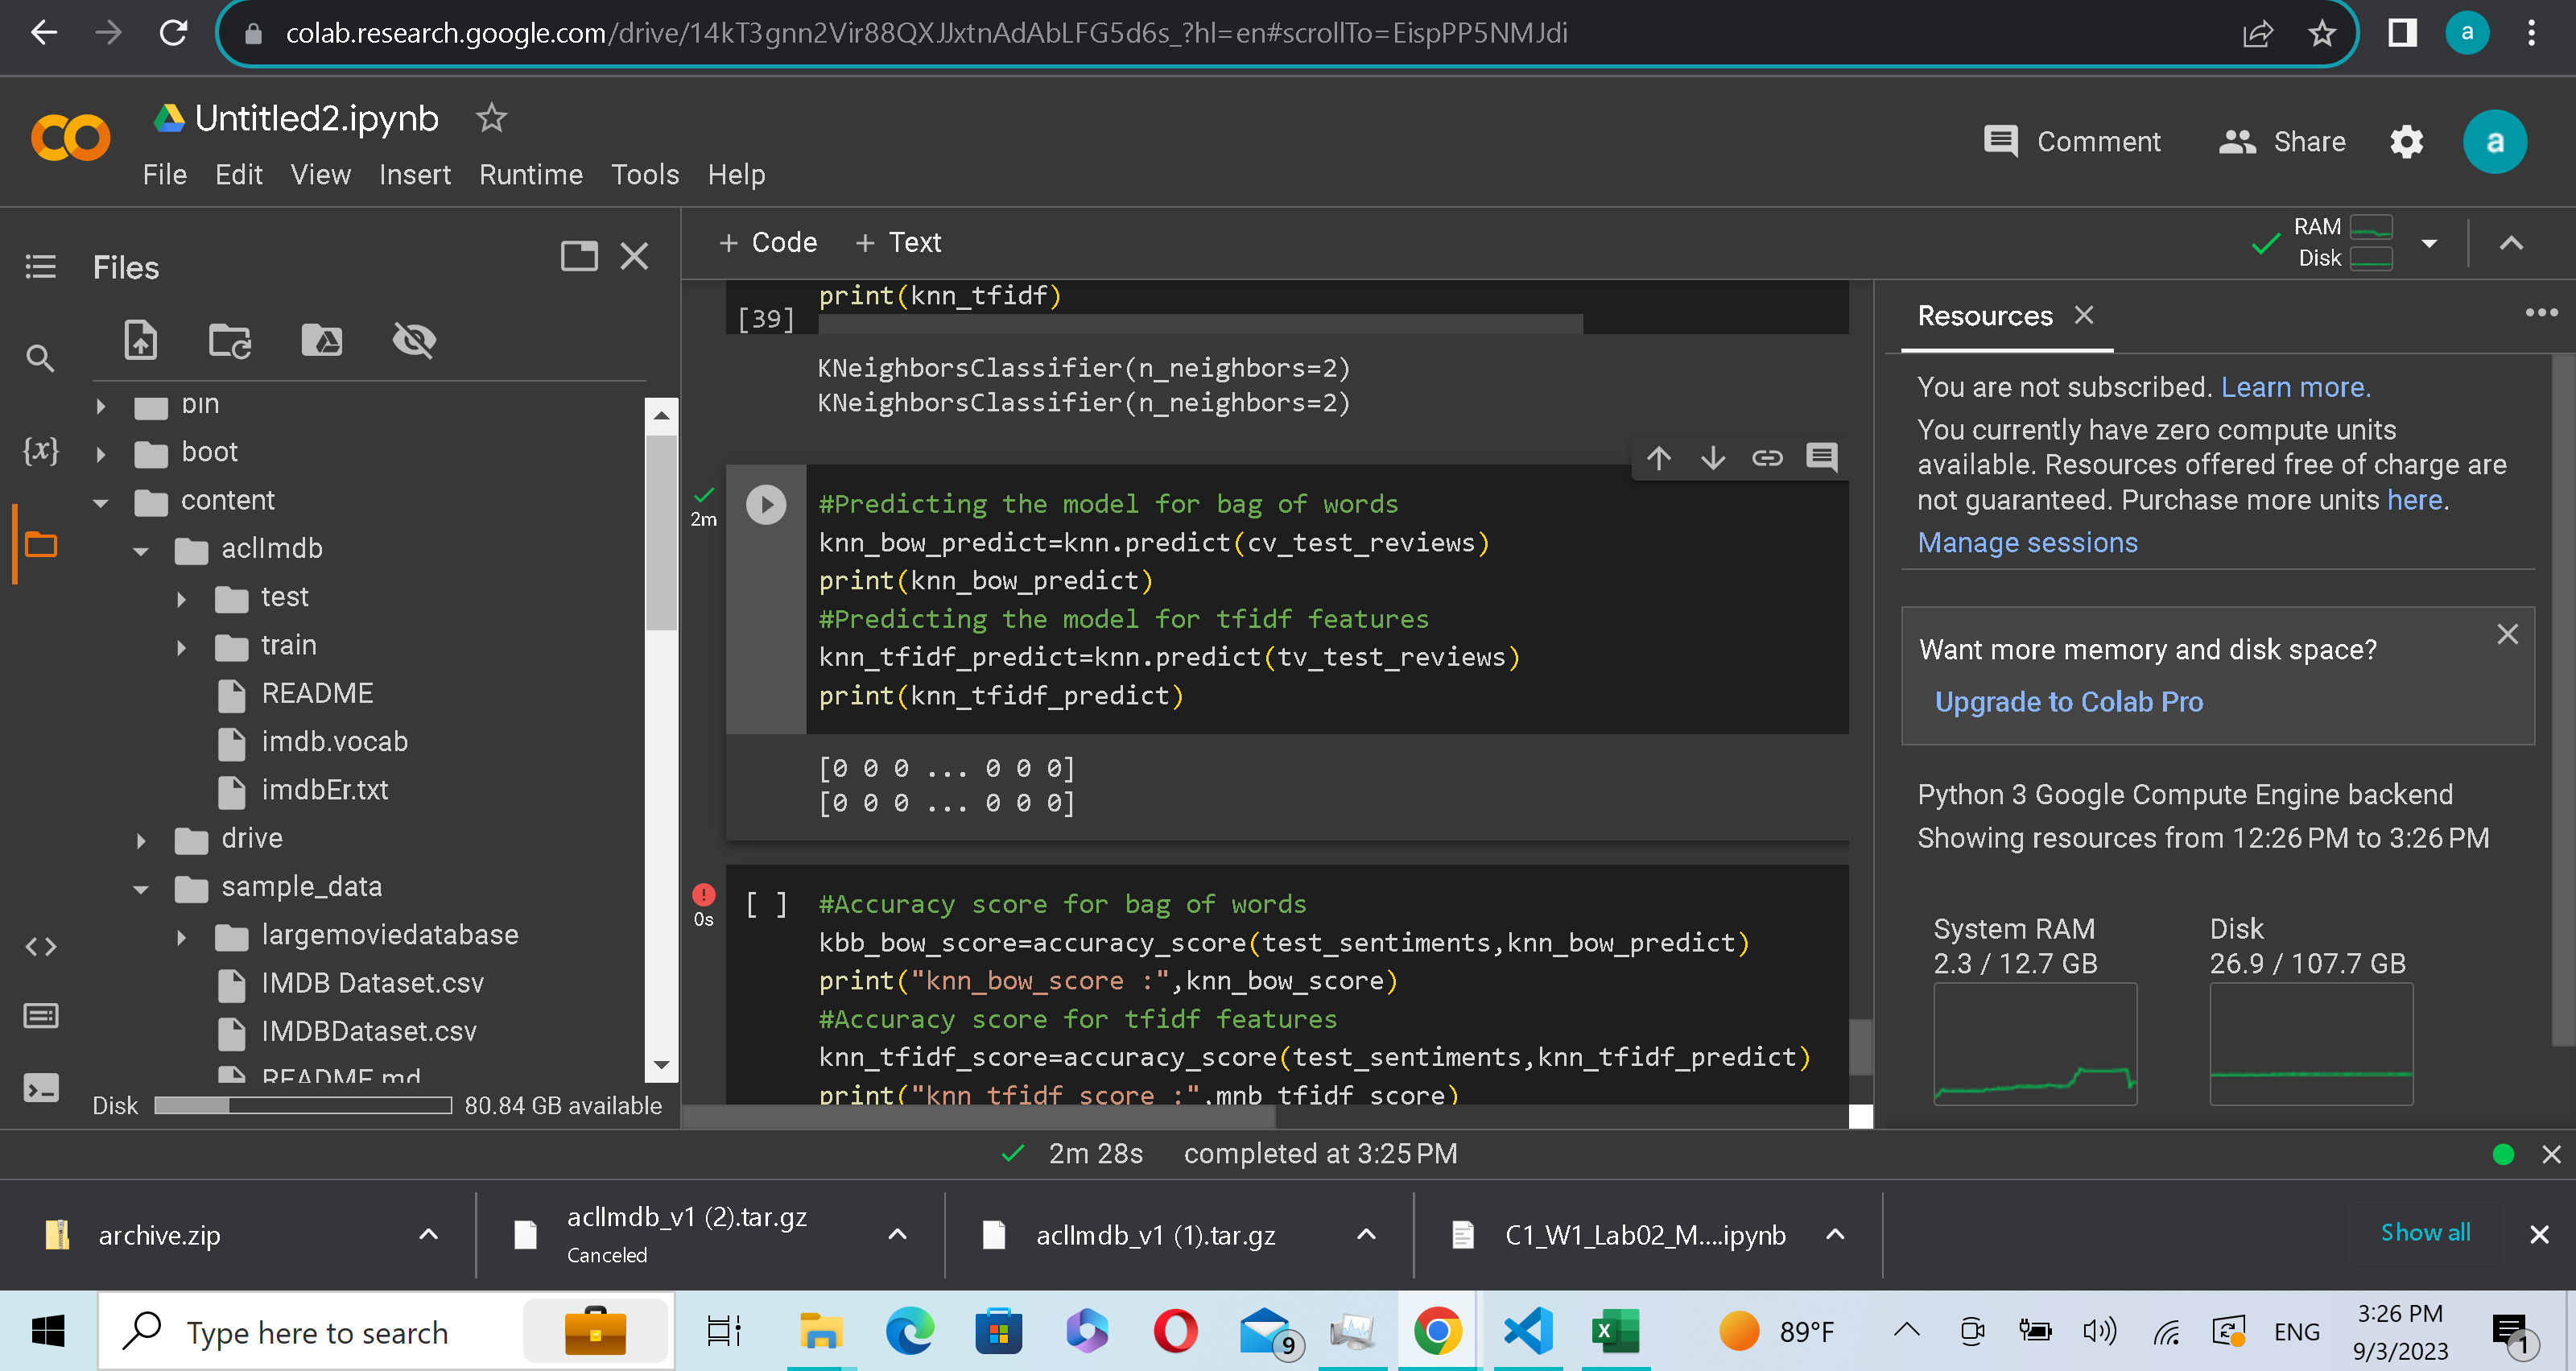

In [ ]:
#Accuracy score for bag of words
knn_bow_score=accuracy_score(test_sentiments,knn_bow_predict)
print("knn_bow_score :",knn_bow_score)
#Accuracy score for tfidf features
knn_tfidf_score=accuracy_score(test_sentiments,knn_tfidf_predict)
print("knn_tfidf_score :",knn_tfidf_score)

knn_bow_score : 0.5147058823529411
knn_tfidf_score : 0.5181197478991597


In [ ]:
#Classification report for bag of words
knn_bow_report=classification_report(test_sentiments,knn_bow_predict,target_names=['Positive','Negative'])
print(knn_bow_report)
#Classification report for tfidf features
knn_tfidf_report=classification_report(test_sentiments,knn_tfidf_predict,target_names=['Positive','Negative'])
print(knn_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.52      0.96      0.67      1973
    Negative       0.46      0.04      0.08      1835

    accuracy                           0.51      3808
   macro avg       0.49      0.50      0.37      3808
weighted avg       0.49      0.51      0.38      3808

              precision    recall  f1-score   support

    Positive       0.52      1.00      0.68      1973
    Negative       0.00      0.00      0.00      1835

    accuracy                           0.52      3808
   macro avg       0.26      0.50      0.34      3808
weighted avg       0.27      0.52      0.35      3808



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Valoarea recall este foarte mica pentru KNN. Cu alte cuvinte sunt prea multe false positives..

In [ ]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,knn_bow_predict,labels=[1,0])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,knn_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[ 372 5452]
 [  78 5906]]
[[   5 5819]
 [   0 5984]]
